In [25]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

behavior = None
experiment_name = 'C01' 
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
 

In [27]:
for isub in range(exp.nsub):
    # Load subject's behavior data
    if behavior is None:
        behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','BlockCondition','ACC','RT']]
    else:
        try:
            temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','BlockCondition','ACC','RT']]
        except:
            print(exp.xdata_files[isub])
        behavior = behavior.append(temp)
behavior = behavior.query("BlockCondition!='L1F'")
behavior.tail()

,Subject,BlockCondition,ACC,RT
957,37,N1,1,556.233960
958,37,N1,1,560.199374
959,37,N1,1,593.038843
960,37,N1,1,497.935042
961,37,N1,1,388.717514


In [28]:
total_means = behavior.groupby(['BlockCondition'])['ACC'].agg(['mean','std']).reset_index()
subject_means = behavior.groupby(['BlockCondition','Subject'])['ACC'].mean().reset_index()

# subject_means['Block Feature'] = subject_means['BlockCondition'].map({0:'Color',1:'Orientation'})
total_means 

,BlockCondition,mean,std
0,2,0.962457,0.190105
1,H1,0.986207,0.116642
2,L1,0.987848,0.109574
3,N1,0.985927,0.117806


In [29]:
subject_means.groupby(['Subject','BlockCondition']).mean()

ACC
Subject BlockCondition          
1       2               1.000000
        H1              1.000000
        L1              1.000000
        N1              1.000000
2       2               0.962406
...                          ...
36      N1              0.970874
37      2               0.951613
        H1              0.991770
        L1              0.974684
        N1              0.991453

[88 rows x 1 columns]

In [30]:
def get_error(query):
    return subject_means.query(query).groupby('Subject').mean().reset_index()['ACC']

In [31]:
pingouin.ttest(get_error('BlockCondition!="2"'),get_error('BlockCondition=="2"'), paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.332958,21,two-sided,0.003157,"[0.01, 0.04]",0.781756,13.227,0.937551


In [32]:
get_error('BlockCondition!="2"').agg(['mean','std'])

mean    0.986881
std     0.013229
Name: ACC, dtype: float64

In [33]:
pingouin.ttest(get_error('BlockCondition=="N1"'),get_error('BlockCondition=="H1"'), paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.128815,21,two-sided,0.89873,"[-0.0, 0.0]",0.015547,0.225,0.050556


In [34]:
pingouin.ttest(get_error('BlockCondition=="N1"'),get_error('BlockCondition=="L1"'), paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.857263,21,two-sided,0.400977,"[-0.01, 0.0]",0.146257,0.31,0.100431


In [35]:
pingouin.ttest(get_error('BlockCondition=="H1"'),get_error('BlockCondition=="L1"'), paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.759493,21,two-sided,0.456,"[-0.01, 0.0]",0.128507,0.289,0.08874


In [36]:
total_means

,BlockCondition,mean,std
0,2,0.962457,0.190105
1,H1,0.986207,0.116642
2,L1,0.987848,0.109574
3,N1,0.985927,0.117806


No handles with labels found to put in legend.


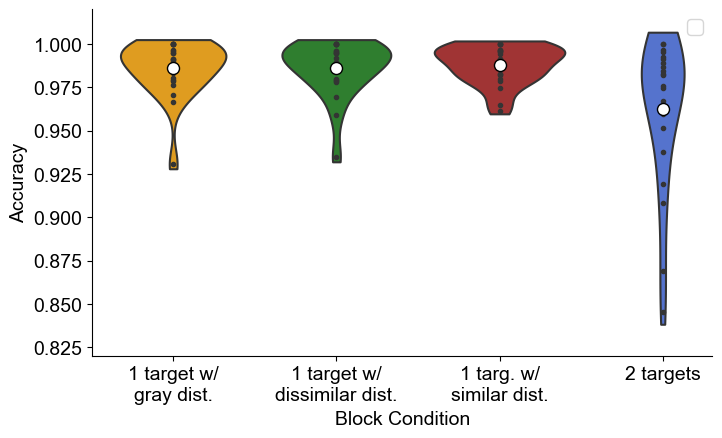

In [37]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,4.5))
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = ax,
    x = 'BlockCondition',
    y = 'ACC',
    data = subject_means,
    dodge=True,
    inner='points',
    palette=my_pal,
    order=["N1","H1","L1","2"],
    cut=.3
)

# plot means
total_mean_vals = total_means['mean'].values
ax.scatter(
    x = [0,1,2,3],
    y = [total_mean_vals[3],total_mean_vals[1],total_mean_vals[2],total_mean_vals[0]],
    c = 'white', edgecolors='k',s=75)

# asethetics
ax.legend(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Block Condition',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
# ax.set_title('Change detection accuracy',fontsize=16)
plt.ylim([.82,1.02])
ax.set_xticklabels(['1 target w/\ngray dist.','1 target w/\ndissimilar dist.','1 targ. w/\nsimilar dist.','2 targets'])
plt.savefig('output/figures/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500,bbox_inches='tight')

plt.show()